# Numba

前面简单了解了下python并行的基本概念，这里记录下Numba这一加速Numpy的库。主要参考了：

- [Numba](https://github.com/numba/numba)
- [Numba: “weapon of mass optimization”](https://towardsdatascience.com/numba-weapon-of-mass-optimization-43cdeb76c7da)
- [Introduction to Numba](https://nyu-cds.github.io/python-numba/)
- [Speed Up your Algorithms Part 2 — Numba](https://towardsdatascience.com/speed-up-your-algorithms-part-2-numba-293e554c5cc1)
- [Introduction to CUDA Python with Numba](https://github.com/shekharidentv/cudaLearning/blob/master/notebooks/Introduction%2Bto%2BCUDA%2BPython%2Bwith%2BNumba.ipynb)

Numba是Python的**即时编译器**（运行前编译，稍后补充基本概念），它使用LLVM从纯python代码优化生成机器码，能加速python代码**数值**（对string不加速）计算**函数**（针对的是Python函数）运行，CPU和GPU上均可。

Numba是否作用取决于代码的情况，如果代码是numerically orientated 的（做大量数学运算），使用NumPy很多和/或有很多循环，那么Numba通常是一个不错的选择，即Numba在使用NumPy数组和函数以及循环的代码上效果最佳。值得注意的是，Numba无法理解Pandas，因此当函数中出现pandas，Numba只会通过解释器运行此代码，会增加Numba内部开销。

使用Numba的最常见方法是通过其装饰器集合，这些装饰器可应用于函数以指示Numba对其进行编译。调用Numba装饰函数时，它会被“即时”编译为机器代码以执行，并且全部或部分代码随后可以本机机器速度运行，这样能在不需要改变语言的情况下获取像C和C++一样的速度！

不过Numba不是在CUDA上编程的唯一方法，不过CUDA编程通常以C/C++来进行，而CUDA提供了一种直接利用Python来编程的方法，能够在改变很少代码的条件下加速运算。

下面是和其他相关CUDA工具的简单对比：

- CUDA C/C++:
    1. 最常用最灵活的 CUDA 编程
    2. 以 C, C ++ 方式加速应用
- pyCUDA
    1. Python上最有效的CUDA形式
    2. 需要在Python代码中编C语言，通常需要很多代码修改
- Numba
    1. 比pyCUDA效率低一些
    2. 可以纯Python编程，需要很少的代码修改即可使用
    3. 也允许CPU上优化Python程序
    
所以在了解更复杂的pyCUDA和CUDA C/C++前，先使用Numba是较好的选择。

本文目标是先学会在CPU上如何使用Numba编译函数，以此进一步了解Numba是如何工作的，最后再学习在GPU上加速Numpy的函数。

可以直接通过conda或者pip安装numba，本repo environment.yml文件中已包含。

开始之前，先了解一些基本概念。

## 基本概念

首先，是Just-in-time Compiling。

### Just-in-time Compiling

Numba的主要特色是numba.jit()装饰。使用此装饰器，可以通过Numba的JIT编译器标记要优化的函数。各种调用模式会触发不同的编译选项和行为。

回顾装饰器基本概念。它是一种以特定方式统一修改功能的方式。可以将它们视为将函数作为输入并产生一个函数作为输出的函数。

函数定义可以由一个或多个装饰器表达式包装。定义函数时，将在包含函数定义的范围中评估装饰器表达式。结果必须是可调用的，它必须以函数对象作为唯一参数来调用。返回的值绑定到函数名称而不是函数对象。多个装饰器以嵌套方式应用。例如，以下代码：

```Python
@f1(arg) 
@f2 
def func(): 
    pass
```

等效于

```Python
def func(): 
    pass 

func = f1(arg)(f2(func))
```

### Function Signatures

还有一个常见概念 -- “Function Signatures”

Function Signatures函数签名描述参数的类型和函数的返回类型。由于编译器无需推断类型，因此生成的代码会稍快一些。但是，该功能不再能够接受其他类型。

In [2]:
from numba import jit, int32, float64

@jit(float64(int32, int32))
def f(x, y):
    # A somewhat trivial example
    return (x + y) / 3.14

在此示例中，float64(int32, int32)函数的签名指定了一个函数，该函数接受两个32位整数参数并返回一个双精度浮点数。Numba提供了一种简写形式，因此可以将相同的签名指定为f8(i4, i4)。

如果省略了返回类型，例如通过写(int32, int32)代替float64(int32, int32)，Numba将尝试推断出它。

### Compilation Modes

Numba有两种编译模式：nopython模式和object模式。

在nopython模式下，Numba编译器将生成不能访问Python C API的代码。此模式产生最高性能的代码，但要求函数中所有值的类型是可以推断出来的。

在object模式下，Numba编译器生成将所有值作为Python对象处理的代码，并使用Python C API对这些对象执行所有操作。在object模式下编译的代码通常不会比Python解释的代码运行得快。

如果nopython模式由于某种原因无法被使用，Numba默认情况下将自动使用object模式。有时最好还是生成错误，而不是退回到object模式。

这里简单介绍下此概念，后面会有更具体的例子。

### Numba Functions

Numba函数可以调用其他Numba函数。当然，两个函数都必须具有@jit装饰器，否则代码会慢很多。

Numba的@vectorize装饰器允许Python函数采用标量输入参数作为NumPy ufuncs。创建传统的NumPy ufunc并不是最简单的过程，它涉及编写一些C代码。Numba可以轻松做到这一点。使用@vectorize装饰器，Numba可以将纯Python函数编译为一个ufunc对NumPy数组进行操作 ，其运行速度与传统C语言 ufuncs 一样快。

ufunc 即 Universal functions，是作用于NumPy的数组每个元素的函数。它们支持数组广播，类型转换和其他几个标准功能。

ufunc是函数的“向量化”包装器，该函数采用固定数量的标量输入并产生固定数量的标量输出。

NumPy的许多内置运算符是ufuncs。

该@vectorize装饰有两种操作模式：

- Eager，或decoration-time，compilation。如果将一个或多个类型签名传递给装饰器，则将构建Numpy ufunc。
- Lazy, 或 call-time, compilation。如果未提供任何签名，则装饰器将提供Numba动态通用函数（DUFunc），当使用以前不受支持的输入类型进行调用时，该函数将动态编译新内核。

使用@vectorize，可以将函数编写为对输入标量（而不是数组）进行操作。Numba将生成周围的循环（或内核），从而允许对实际输入进行有效的迭代。以下代码定义了一个函数，该函数接受两个整数数组并返回一个整数数组。

In [3]:
import numpy as np
from numba import vectorize, int64

@vectorize([int64(int64, int64)])
def vec_add(x, y):
    return x + y

a = np.arange(6, dtype=np.int64)
b = np.linspace(0, 10, 6, dtype=np.int64)
print(a)
print(b)
print(vec_add(a, a))
print(vec_add(b, b))

[0 1 2 3 4 5]
[ 0  2  4  6  8 10]
[ 0  2  4  6  8 10]
[ 0  4  8 12 16 20]


## Compile for the CPU

使用Python函数装饰器即可实现CPU上对代码的加速。

In [4]:
from numba import jit
import numpy as np
import math

@jit
def hypot(x, y):
    return math.sqrt(x*x + y*y)

# Numba function
hypot(3.0, 4.0)

5.0

In [5]:
# Python function
hypot.py_func(3.0, 4.0)

5.0

可以看到Numba的结果和python本身函数的结果是一致的。现在衡量Numba的性能，如何做？

因为Numba必须在执行函数的机器代码版本之前针对给定的参数类型编译函数。但是，一旦编译完成，Numba会为呈现的特定类型的参数缓存函数的机器代码版本。如果使用相同类型再次调用，则它可以重用缓存的版本，而不必再次编译。而衡量性能时，一个真正常见的错误是不考虑上述行为，并使用一个简单的计时器对代码进行一次计时，该计时器包括在执行时间中编译函数所花费的时间。

所以衡量Numba JIT对代码的影响的方法通常是使用timeit模块函数对执行时间进行计时，这些函数测量执行的多次迭代，因此可以使其适应第一次执行时的编译时间。

比如我们一般衡量时间方式如下，可用看到编译的影响。

In [6]:
from numba import jit
import numpy as np
import time

x = np.arange(100).reshape(10, 10)

@jit(nopython=True)
def go_fast(a): # Function is compiled and runs in machine code
    trace = 0.0
    for i in range(a.shape[0]):
        trace += np.tanh(a[i, i])
    return a + trace

# DO NOT REPORT THIS... COMPILATION TIME IS INCLUDED IN THE EXECUTION TIME!
start = time.time()
go_fast(x)
end = time.time()
print("Elapsed (with compilation) = %s" % (end - start))

# NOW THE FUNCTION IS COMPILED, RE-TIME IT EXECUTING FROM CACHE
start = time.time()
go_fast(x)
end = time.time()
print("Elapsed (after compilation) = %s" % (end - start))

Elapsed (with compilation) = 0.4015069007873535
Elapsed (after compilation) = 0.0


采用 timeit来衡量：

In [7]:
import math

# Python function
%timeit hypot.py_func(3.0, 4.0)

372 ns ± 22.9 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [8]:
# Numba function
%timeit hypot(3.0, 4.0)

207 ns ± 6.13 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [9]:
# math function
%timeit math.hypot(3.0, 4.0)

125 ns ± 5.84 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


可以看到最快的是math函数，这是因为Numba会给每个函数调用带来一定的开销，该开销要大于Python函数调用的开销，因此非常快的函数会受到此影响。

但是，如果从另一个函数调用Numba函数，则开销很少，如果编译器将该函数集成到另一个函数中，则有时甚至为零。总之，要注意检查函数是否真的在Numba中加速了。

那么Numba到底有多快？

加速因应用而异，但可以是一到两个数量级。

## How does Numba work?

那么Numba是如何加速的？

![](pictures/1_S0S4QUjR-BsdTICtT9797Q.png)

其中，

- IR是Intermediate Representations
- Bytecode Analysis是 Intermediate code，比 machine code 更抽象
- LLVM 全称 Low Level Virtual Machine, 编译器基础
- NVVM 是一个基于 LLVM 的 IR compiler, 涉及用来表示 GPU kernels

Numba读取装饰函数的Python字节码，并将其与有关函数输入参数类型的信息结合起来。它会分析和优化代码，最后使用LLVM编译器库生成针对CPU能力定制的函数的机器代码版本。然后，每次调用函数时都会使用此编译版本。

简而言之，就是把python函数用numba的方式表示，然后重新整理后输入LLVM，来执行。

每行python之前都有几行Numba IR代码。最有用的是查看 向我们展示Numba如何处理变量的类型注释，使用.inspect_types()：

In [10]:
@jit
def foo_np(x):
    return np.sin(x)

In [11]:
foo_np(2)

0.9092974268256817

In [12]:
foo_np.inspect_types()

foo_np (int64,)
--------------------------------------------------------------------------------
# File: C:\Users\hust2\AppData\Local\Temp/ipykernel_11636/2047400942.py
# --- LINE 1 --- 

@jit

# --- LINE 2 --- 

def foo_np(x):

    # --- LINE 3 --- 
    # label 0
    #   x = arg(0, name=x)  :: int64
    #   $2load_global.0 = global(np: <module 'numpy' from 'C:\\Users\\hust2\\miniconda3\\envs\\hydrus\\lib\\site-packages\\numpy\\__init__.py'>)  :: Module(<module 'numpy' from 'C:\\Users\\hust2\\miniconda3\\envs\\hydrus\\lib\\site-packages\\numpy\\__init__.py'>)
    #   $4load_method.1 = getattr(value=$2load_global.0, attr=sin)  :: Function(<ufunc 'sin'>)
    #   del $2load_global.0
    #   $8call_method.3 = call $4load_method.1(x, func=$4load_method.1, args=[Var(x, 2047400942.py:3)], kws=(), vararg=None)  :: (int64,) -> float64
    #   del x
    #   del $4load_method.1
    #   $10return_value.4 = cast(value=$8call_method.3)  :: float64
    #   del $8call_method.3
    #   return $10return

再看个例子--创建分形

将衡量使用Mandelbrot集创建分形的性能，看Numba如何帮助改善性能。

6.49 s ± 106 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


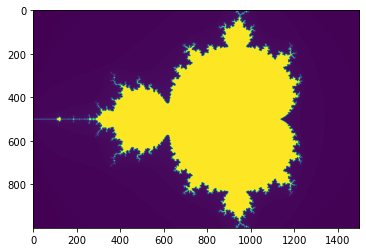

In [13]:
# Without Numba
from matplotlib.pylab import imshow, ion

def mandel(x, y, max_iters):
    i = 0
    c = complex(x,y)
    z = 0.0j
    for i in range(max_iters):
        z = z*z + c
        if (z.real*z.real + z.imag*z.imag) >= 4:
            return i

    return 255

def create_fractal(min_x, max_x, min_y, max_y, image, iters):
    height = image.shape[0]
    width = image.shape[1]

    pixel_size_x = (max_x - min_x) / width
    pixel_size_y = (max_y - min_y) / height
    for x in range(width):
        real = min_x + x * pixel_size_x
        for y in range(height):
            imag = min_y + y * pixel_size_y
            color = mandel(real, imag, iters)
            image[y, x] = color

    return image

image = np.zeros((500 * 2, 750 * 2), dtype=np.uint8)
%timeit create_fractal(-2.0, 1.0, -1.0, 1.0, image, 20)
img = create_fractal(-2.0, 1.0, -1.0, 1.0, image, 20)
imshow(img)

现在看看使用Numba加速的效果：

48.5 ms ± 2.31 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


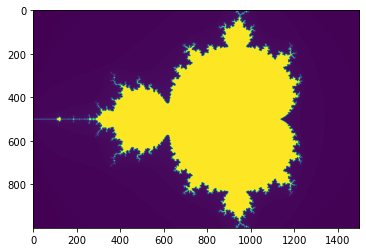

In [14]:
# With Numba
from matplotlib.pylab import imshow, ion

@jit
def mandel(x, y, max_iters):
    """
    Given the real and imaginary parts of a complex number,
    determine if it is a candidate for membership in the Mandelbrot
    set given a fixed number of iterations.
    """
    i = 0
    c = complex(x,y)
    z = 0.0j
    for i in range(max_iters):
        z = z*z + c
        if (z.real*z.real + z.imag*z.imag) >= 4:
            return i

    return 255

@jit
def create_fractal(min_x, max_x, min_y, max_y, image, iters):
    height = image.shape[0]
    width = image.shape[1]

    pixel_size_x = (max_x - min_x) / width
    pixel_size_y = (max_y - min_y) / height
    for x in range(width):
        real = min_x + x * pixel_size_x
        for y in range(height):
            imag = min_y + y * pixel_size_y
            color = mandel(real, imag, iters)
            image[y, x] = color

    return image

image = np.zeros((500 * 2, 750 * 2), dtype=np.uint8)
%timeit create_fractal(-2.0, 1.0, -1.0, 1.0, image, 20)
img = create_fractal(-2.0, 1.0, -1.0, 1.0, image, 20)
imshow(img)

可以看到从几秒提高到了几十毫秒，百倍的速度变化，仅仅只是加了一个装饰器！！！

另外，有一些常见的错误需要注意，比如 Numba 仅对数值函数起作用，对比如dictionaries是不起作用的

In [15]:
@jit
def dictionary(dict_test):
    return dict_test['house']
dictionary({'house': 2, 'car': 35})

C:\Users\hust2\AppData\Local\Temp/ipykernel_11636/488643721.py:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "dictionary" failed type inference due to: non-precise type pyobject
During: typing of argument at C:\Users\hust2\AppData\Local\Temp/ipykernel_11636/488643721.py (3)

File "..\..\..\..\Users\hust2\AppData\Local\Temp\ipykernel_11636\488643721.py", line 3:
<source missing, REPL/exec in use?>

  @jit
C:\Users\hust2\miniconda3\envs\hydrus\lib\site-packages\numba\core\object_mode_passes.py:151: NumbaWarning: Function "dictionary" was compiled in object mode without forceobj=True.

File "..\..\..\..\Users\hust2\AppData\Local\Temp\ipykernel_11636\488643721.py", line 1:
<source missing, REPL/exec in use?>

  warnings.warn(errors.NumbaWarning(warn_msg,
C:\Users\hust2\miniconda3\envs\hydrus\lib\site-packages\numba\core\object_mode_passes.py:161: NumbaDeprecationWarning: 
Fall-back from the nopython compilation path to the object mod

2

再比如pandas下也不能使用Numba模式。

In [16]:
from numba import jit
import pandas as pd

x = {'a': [1, 2, 3], 'b': [20, 30, 40]}

@jit
def use_pandas(a): # Function will not benefit from Numba jit
    df = pd.DataFrame.from_dict(a) # Numba doesn't know about pd.DataFrame
    df += 1                        # Numba doesn't understand what this is
    return df.cov()                # or this!

print(use_pandas(x))

      a      b
a   1.0   10.0
b  10.0  100.0


C:\Users\hust2\AppData\Local\Temp/ipykernel_11636/2792547010.py:6: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "use_pandas" failed type inference due to: non-precise type pyobject
During: typing of argument at C:\Users\hust2\AppData\Local\Temp/ipykernel_11636/2792547010.py (8)

File "..\..\..\..\Users\hust2\AppData\Local\Temp\ipykernel_11636\2792547010.py", line 8:
<source missing, REPL/exec in use?>

  @jit
C:\Users\hust2\miniconda3\envs\hydrus\lib\site-packages\numba\core\object_mode_passes.py:151: NumbaWarning: Function "use_pandas" was compiled in object mode without forceobj=True.

File "..\..\..\..\Users\hust2\AppData\Local\Temp\ipykernel_11636\2792547010.py", line 6:
<source missing, REPL/exec in use?>

  warnings.warn(errors.NumbaWarning(warn_msg,
C:\Users\hust2\miniconda3\envs\hydrus\lib\site-packages\numba\core\object_mode_passes.py:161: NumbaDeprecationWarning: 
Fall-back from the nopython compilation path to the object

如上所示，虽然没有报错，但是警告了。Numba创建了两个函数，一个Python，一个Numba，这里Numba不起作用，看到的就是Python函数，可使用 nopython = True 来验证。

In [17]:
@jit(nopython = True)
def dictionary(dict_test):
    return dict_test['house']
dictionary({'house': 2, 'car': 35})

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1mnon-precise type pyobject[0m
[0m[1mDuring: typing of argument at C:\Users\hust2\AppData\Local\Temp/ipykernel_11636/2718918373.py (3)[0m
[1m
File "..\..\..\..\Users\hust2\AppData\Local\Temp\ipykernel_11636\2718918373.py", line 3:[0m
[1m<source missing, REPL/exec in use?>[0m

This error may have been caused by the following argument(s):
- argument 0: [1mCannot determine Numba type of <class 'dict'>[0m


可用看到没有python模式后，单纯的Numba模式下会报错。

稍微解释下什么是nopython模式。

Numba@jit装饰器从根本上以两种编译模式（nopython模式和object模式）运行。nopython=True是在@jit装饰器中设置的，它指示Numba以nopython模式运行。nopython编译模式的行为实质上是编译装饰后的函数，以便其完全运行而无需Python解释器的参与。这是使用Numba jit装饰器的推荐和最佳实践方法，因为它可以带来最佳性能。

如果在nopython模式下编译失败，则Numba可以使用object mode进行编译 ，在这种模式下，Numba将识别可以编译的循环并将其编译为在机器代码中运行的函数，并将在解释器中运行其余代码。为了获得最佳性能，请避免使用此模式！

## Numba for GPU

Numba可以针对Nvidia CUDA和AMD ROC GPU。可以使用纯Python编写内核，并让Numba处理计算和数据移动。但是在GPU上运行程序并不简单，所以下面的内容更多地是简单了解即可。

要使用CUDA的话，需要安装[CUDA SDK](https://developer.nvidia.com/cuda-downloads)，安装时候要参考[NVIDIA官网文档](https://docs.nvidia.com/cuda/cuda-installation-guide-microsoft-windows/index.html)，[并设置相应的环境](https://numba.pydata.org/numba-doc/dev/cuda/overview.html#cudatoolkit-lookup)，如果是Linux下，Numba会自动给检测全局安装的CUDA库。注意如果本机无法安装CUDA，那么后面的内容就不能尝试运行了。

使用Numba又两种GPU编程方式：

1. ufuncs/gufuncs__
2. CUDA Python Kernels

### Functions ufunc

GPU的主要设计功能之一是能够并行处理数据，因此numpy的通用函数（ufunc）是在GPU编程中实现它们的理想选择。

注：ufunc是对numpy数组的每个元素执行相同操作的函数。例如：

In [15]:
import numpy as np

# Ufunc
a = np.array([1, 2, 3, 4])
b = np.array([23, 341, 12, 5])

np.add(a, b)

# It can also be used with scalars.
np.add(b, 200)

# Arrays of different dimensions can also be operated using a technique called broadcasting. 
c = np.array([2, 3, 7, 8, 10, 34])
d = np.arange(6*6).reshape((6,6))

print('c array: \n', c)
print('\nd array: \n', d)
print('\n')

np.add(c, d)

c array: 
 [ 2  3  7  8 10 34]

d array: 
 [[ 0  1  2  3  4  5]
 [ 6  7  8  9 10 11]
 [12 13 14 15 16 17]
 [18 19 20 21 22 23]
 [24 25 26 27 28 29]
 [30 31 32 33 34 35]]




array([[ 2,  4,  9, 11, 14, 39],
       [ 8, 10, 15, 17, 20, 45],
       [14, 16, 21, 23, 26, 51],
       [20, 22, 27, 29, 32, 57],
       [26, 28, 33, 35, 38, 63],
       [32, 34, 39, 41, 44, 69]])

如前所述，由于ufunc函数具有并行性，因此是将其与GPU配合使用的理想选择。因此，Numba无需使用C即可创建已编译的ufunc函数。为此，我们必须使用decorator @vectorize。

从一个@vectorize用于编译和优化CPU ufunc的示例开始。

In [23]:
from numba import vectorize

a = np.array([1, 2, 3, 4])
b = np.array([23, 341, 12, 5])

@vectorize
def add_ufunc_cpu(a, b):
    return a + b

# Numba function
add_ufunc_cpu(a, b)

array([ 24, 343,  15,   9], dtype=int64)

要想不使用CPU来编译和执行先前的功能，而在GPU中使用CUDA，必须使用“目标属性”。指出每个变量的类型（参数和返回值）：

```Python
return_value_type(argument1_value_type, argument2_value_type, ...)
```

使用上面的函数，该函数期望2个int32值并返回另一个int32值（电脑不同可能不同，我的是int32，参考资料中给的例子是int64）。指定target = 'cuda'能够在GPU中执行它。

In [24]:
@vectorize(['int32(int32, int32)'], target='cuda') 
def add_ufunc_gpu(x, y):
    return x + y
 
add_ufunc_gpu(a, b)

array([ 24, 343,  15,   9])

下面看看执行的时间

In [25]:
%timeit np.add(a, b)   # Numpy en CPU

586 ns ± 26.4 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [26]:
%timeit add_ufunc_gpu(a, b)   # Numpy en GPU

1.45 ms ± 193 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


GPU比CPU慢！不过这有解释的，先看看调用函数时发生了什么。

我们执行此功能时，Numba会产生：

1. 编译CUDA内核以在输入数组的所有元素上并行执行ufunc函数
2. 将输入和输出分配给GPU内存
3. 将输入复制到GPU
4. 运行CUDA内核
5. 将结果从GPU复制回CPU
6. 以numpy数组形式返回结果

与用C实现相比，Numba允许以更简洁的方式执行这些类型的任务。

为什么GPU比CPU慢？

- 输入量太小：GPU使用一次并行处理数千个值的并行处理来获得更好的性能。我们的输入是4或64维，我们需要更大的数组来保持GPU的占用。
- 非常简单的计算：与调用CPU函数相比，将计算结果发送到GPU需要很多“精力”。如果我们的函数不需要过多的数学计算（通常称为*算术强度*），那么GPU所需的时间可能比CPU中的时间长。
- Numba将数据复制到GPU。
- 我们输入的变量类型大于必要的变量：我们的示例使用int32，所以没这个问题，不过值得一提，有时候我们使用int64的时候可我们并不需要它们。实际上，在CPU中，32位和64位具有相同的计算速度，但是在GPU中，64位与32位相比，其速度可降低多达24倍。因此，在GPU中执行我们的功能时，请记住这一点，这一点很重要。

考虑到这一点，我们将尝试应用在前面几点中学到的知识，以了解在GPU上运行是否真的比在CPU上运行更快。我们将计算一个密度函数，这对于较大的数组来说是一个稍微复杂的操作。

让我们以x给定的均值和sigma计算高斯密度函数的值：

In [27]:
import math

sqrt_pi = np.float32((2*math.pi)**0.5) 

@vectorize(['float32(float32, float32, float32)'], target='cuda')
def gaussian_dens_gpu(x, mean, sigma):
    return math.exp(-0.5 * ((x - mean) / sigma)**2) / (sigma * sqrt_pi)
  
x = np.random.uniform(-3, 3, size=1000000).astype(np.float32)
mean = np.float32(0.0)
sigma = np.float32(1.0)

# We use scipy to perform the same calculation but on the CPU and compare it with the GPU
import scipy.stats 

norm_pdf = scipy.stats.norm

In [28]:
%timeit norm_pdf.pdf(x, loc=mean, scale=sigma)  # CPU function

102 ms ± 3.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [29]:
%timeit gaussian_dens_gpu(x, mean, sigma) # GPU function

12.3 ms ± 1.62 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


可用看到GPU中速度更快了。

我们还可以使用Numba定义要在CPU中执行的功能。

In [30]:
import math 

sqrt_pi = np.float32((2*math.pi)**0.5)

@vectorize
def gaussian_dens_cpu(x, mean, sigma):
    return math.exp(-0.5 * ((x - mean) / sigma)**2) / (sigma * sqrt_pi)
  
x = np.random.uniform(-3, 3, size=1000000).astype(np.float32)
mean = np.float32(0.0)
sigma = np.float32(1.0)

%timeit gaussian_dens_cpu(x, mean, sigma) # CPU

17.6 ms ± 2.24 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


可以看到，它甚至比用Python编写的函数还要快，但比在GPU中执行的函数要慢。

不幸的是，有几个函数不在ufunc定义的范围内，因此，要在GPU中执行不满足我们使用的要求的函数，要使用cuda.jit。我们可以使用在GPU上运行的“devices functions”。

注意：“devices functions”是只能从内核或另一个“设备”函数调用的功能。

In [31]:
from numba import cuda

# Device function
@cuda.jit(device=True)
def polar_to_cartesian(rho, theta):
    x = rho * math.cos(theta)
    y = rho * math.sin(theta)
    return x, y

@vectorize(['float32(float32, float32, float32, float32)'], target='cuda')
def polar_distance(rho1, theta1, rho2, theta2):
    x1, y1 = polar_to_cartesian(rho1, theta1)
    x2, y2 = polar_to_cartesian(rho2, theta2)
    
    return ((x1 - x2)**2 + (y1 - y2)**2)**0.5
    
n = 1000000
rho1 = np.random.uniform(0.5, 1.5, size=n).astype(np.float32)
theta1 = np.random.uniform(-np.pi, np.pi, size=n).astype(np.float32)
rho2 = np.random.uniform(0.5, 1.5, size=n).astype(np.float32)
theta2 = np.random.uniform(-np.pi, np.pi, size=n).astype(np.float32)

In [32]:
%timeit polar_distance(rho1, theta1, rho2, theta2)

27.8 ms ± 2.18 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### CUDA Python kernel

这部分涉及到一些CUDA编程的基本知识，第一次见略显晦涩，所以这里暂时只简单地列出了一些概念，后续需要CUDA编程再进一步补充。

Numba通过按照CUDA执行模型将Python代码的受限子集直接编译到CUDA内核和设备函数中，从而支持CUDA GPU编程。

Numba显著简化了编写GPU内核的功能之一，使该内核似乎可以直接访问NumPy数组。作为内核参数提供的NumPy数组会在CPU和GPU之间自动传输（尽管这也可能是一个问题）。

Numba尚未实现完整的CUDA API，因此某些功能不可用。但是，提供的功能足以开始尝试编写GPU支持内核。Numba中的CUDA支持正在积极开发中，因此最终大多数功能都应该可用。

先列出CUDA编程主题中的几个重要术语：

- host：CPU
- device：GPU
- host memory：系统主内存
- device memory：GPU卡上的板载内存
- kernel：由主机启动并在设备上执行的GPU功能
- device function：在设备上执行的GPU函数，只能从设备（即，从内核或其他设备函数）调用

#### 管理设备

可以使用以下命令获取系统中所有GPU的列表：

In [1]:
from numba import cuda
print(cuda.gpus)

<Managed Device 0>


如果系统上没有启用CUDA的GPU，则会收到以下错误之一：

```Shell
numba.cuda.cudadrv.error.CudaDriverError: CUDA initialized before forking
```

```Shell
CudaSupportError: Error at driver init: 
[3] Call to cuInit results in CUDA_ERROR_NOT_INITIALIZED:
```

```Shell
numba.cuda.cudadrv.error.CudaDriverError: Error at driver init:
CUDA disabled by user:
```

本机装有一个有CUDA的GPU，所以显示如上。

如果计算机具有多个GPU，则可能要选择要使用的GPU。默认情况下，CUDA驱动程序选择最快的GPU作为设备0，这是Numba使用的默认设备。

```Shell
numba.cuda.select_device(device_id)
```

该命令将为选定的device_id创建新的CUDA上下文环境。device_id应该是设备的编号（从0开始；设备顺序由CUDA库确定）。上下文与当前线程关联。Numba当前每个线程仅允许一个上下文。

如果没有启用CUDA的GPU（即，收到了上述错误消息之一），则需要使用CUDA仿真器。通过将环境变量NUMBA_ENABLE_CUDASIM设置为1来启用模拟器。

Mac / Linux下，启动终端外壳并键入以下命令：

```Shell
export NUMBA_ENABLE_CUDASIM=1
```

Windows下，启动CMD Shell并键入以下命令：

```Shell
SET NUMBA_ENABLE_CUDASIM=1
```

现在，重新运行“设备列表”命令，并检查是否获得正确的输出。

接下来尝试编写CUDA kernels。

#### 写CUDA kernels

CUDA具有与用于CPU编程的传统顺序模型不同的执行模型。在CUDA中，编写的代码将同时由多个线程（通常成百上千个）执行。将通过定义grid，block和threads构成的thread hierarchy来建模。

Numba暴露了三种GPU内存：

- global device memory
- shared memory
- local memory

对于除最简单算法以外的所有算法，务必仔细考虑如何使用和访问内存，以最大程度地减少带宽要求和争用，这一点很重要。

NVIDIA建议程序员关注以下建议以获得最佳性能：

- 寻找使顺序代码并行化的方法
- 最小化主机与设备之间的数据传输
- 调整内核启动配置以最大化设备利用率
- 确保合并全局内存访问
- 尽可能减少对全局内存的冗余访问
- 避免在同一warp中使用不同的执行路径

##### Kernel declaration

kernel function 是一种GPU 函数，可以从CPU代码中调用。它具有两个基本特征：

- kernel无法显式返回值；所有结果数据都必须写入传递给函数的数组中（如果计算的是标量，则可能传递一个单元素数组）；
- kernel在被调用时显式声明其线程层次结构：即线程块数和每个块的线程数（请注意，虽然kernel仅编译一次，但可以使用不同的块大小或网格大小多次调用它）。

```Python
from numba import cuda

@cuda.jit
def my_kernel(io_array):
    """
    Code for kernel.
    """
    # code here
```

##### Kernel invocation

通常以以下方式启动内核：

```Python
import numpy

# Create the data array - usually initialized some other way
data = numpy.ones(256)

# Set the number of threads in a block
threadsperblock = 32 

# Calculate the number of thread blocks in the grid
blockspergrid = (data.size + (threadsperblock - 1)) // threadsperblock

# Now start the kernel
my_kernel[blockspergrid, threadsperblock](data)

# Print the result
print(data)
```

主要有两个步骤：

1. 通过指定每个网格的块数和每个块的线程数来实例化内核。两者的乘积将给出启动的线程总数。内核实例化是通过采用已编译的内核函数并用整数元组对其进行索引来完成的。
2. 通过将输入数组（以及必要时的任何单独的输出数组）传递给内核来运行内核。默认情况下，内核运行是同步的：内核完成执行并且数据同步返回后，该函数将返回。

由于以下原因，两级线程层次结构很重要：

- 在软件方面，块大小确定多少线程共享共享内存的给定区域。
- 在硬件方面，块的大小必须足够大以完全占用执行单元。

选择的块大小取决于一系列因素，包括：

- 数据数组的大小
- 每块共享内存的大小（例如64KB）
- 硬件支持的每个块的最大线程数（例如512或1024）
- 每个多处理器（MP）的最大线程数（例如2048）
- 每个MP的最大块数（例如32）
- 可以同时执行的线程数（“ warp”，即32）

线程束中的线程执行对计算吞吐量有很大影响。如果warp中的所有线程都在执行同一指令，那么它们都可以并行执行。但是，如果一个或多个线程正在执行另一条指令，则必须将warp分成线程组，并且这些组将顺序执行。

每块线程的经验法则：

- 应该是warp 大小的整数倍（32）
- 一个很好的起点是128-512，但是需要基准测试来确定最佳值。

GPU上的每个流式多处理器（SP）必须具有足够的活动扭曲以实现最大吞吐量。换句话说，通常选择块大小以最大化“占用率”。

#### Thread positioning

运行内核时，内核函数的代码由每个线程执行一次。因此，它必须知道它在哪个线程中，以便知道它负责哪个数组元素。更复杂的算法可能定义了更复杂的职责，但是基本原理是相同的。

为了帮助处理多维数组，CUDA允许指定多维块和网格。在上面的示例中，可以使blockspergrid和threadsperblock元组为一个，两个或三个整数。与等效大小的一维声明相比，这不会改变所生成代码的效率或行为，但可以帮助以更自然的方式编写算法。

一种方法是让线程确定其在网格和块中的位置，然后手动计算相应的数组位置：

```Python
@cuda.jit
def my_kernel(io_array):
    # Thread id in a 1D block
    tx = cuda.threadIdx.x
    # Block id in a 1D grid
    ty = cuda.blockIdx.x
    # Block width, i.e. number of threads per block
    bw = cuda.blockDim.x
    # Compute flattened index inside the array
    pos = tx + ty * bw
    if pos < io_array.size:  # Check array boundaries
        io_array[pos] *= 2 # do the computation
```

注意：除非确定块大小和网格大小是阵列大小的除数，否则必须如上所述检查边界。

CUDA后端提供以下特殊对象，其唯一目的是了解线程层次结构的几何图形以及当前线程在该几何图形中的位置：

- numba.cuda.threadIdx-当前线程块中的线程索引。对于一维块，索引（由x属性给出）是一个整数，范围从0到numba.cuda.blockDim-1。当使用多个维度时，每个维度都存在类似的规则。
- numba.cuda.blockDim-实例化内核时声明的线程块的形状。对于给定内核中的所有线程，即使它们属于不同的块（即，每个块“已满”），该值也相同。
- numba.cuda.blockIdx-线程网格中的块索引启动了内核。对于一维网格，索引（由x属性赋予）是一个整数，范围从0到numba.cuda.gridDim-1。当使用多个维度时，每个维度都存在类似的规则。
- numba.cuda.gridDim -实例化内核时声明的块网格形状，即此内核调用启动的块总数。

这些对象可以是1维，2维或3维的，具体取决于调用内核的方式。在每个维度访问该值，可使用x，y并z 分别这些对象的属性。

简单的算法将倾向于总是以与上例所示相同的方式使用线程索引。Numba提供了其他工具来自动执行此类计算：

numba.cuda.grid(ndim)-返回当前线程在整个块网格中的绝对位置。ndim应该与实例化内核时声明的维数相对应。如果ndim为1，则返回一个整数。如果ndim为2或3，则返回给定整数的元组。
numba.cuda.gridsize(ndim)-返回整个块网格中螺纹的绝对尺寸（或形状）。ndim具有与上述相同的含义 grid()。

以上简单介绍了CUDA编程的一些概念，后续内容暂略，将来补充。

总而言之，Numba是一个Python编译器，专门用于数值函数，它允许我们直接用Python编写高性能函数来加速应用程序。

它是一个稳定的工具，可以优化面向数组的代码。由于它的易用性（只需一个装饰器！），它为我们提供了一个非常强大的工具来改善代码的性能。

最后，如果想要更多地了解GPU编程相关的内容，还需要进一步地去了解CUDA的基本编程，这有需要对C有所认识，略微需要更多基础，所以视情况，以后再补充了。